In [485]:
using DifferentialEquations
using ReactionMechanismSimulator
using PyPlot

In [486]:
outdict = readinput("chem300.rms")

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [487]:
liqspcs = outdict["gas"]["Species"]
liqrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [488]:
sitedensity = 2.292e-5; # Ag111
liq = IdealDiluteSolution(liqspcs,liqrxns,solv,name="liquid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [489]:
# Reservoir is a 100 mL (100e-6 m^3) cell
# Proton concentration is 10^-7 mol/L (10^-4 mol/m^3)
# CO2 concentration is 0.01 mol/L (10 mol/m^3), saturation solubility ~0.03 mol/L
# AVratio in experiments is 36 m^-1 but is measured by surface area/reservoir volume
# Area of the electrode is therefore 3.6e1 m^-1 * 1e2*1e-6 m^3 = 3.6e-3 m^2 = 36 cm^2
# Assume boundary layer thickness d_bl = 1 mm or 1e-3 m
# Volume of the boundary layer V_bl = 3.6e-3 m^2 * 1e-3 m = 3.6e-6 m^3
# Actual AVratio is therefore 3.6e-3 m^2 / 3.6e-6 m^3 = 1e3 m^-1 (reciprocal of d_bl)
# Amount of sites is 2.292e-5 mol/m^2 * 1e3 m^-1 = 2.292e-2 mol/m^-3

C_proton = 1e-7*1e3;
C_co2 = 1e-2*1e3;
C_default = 1e-12;
V_res = 100.0e-6;
AVratio = 1e3;
A_surf = 100.0e-6*36;
V_bl = A_surf/AVratio;
sites = sitedensity;

initialcondsliq = Dict(["proton"=>C_proton,
                        "CO2"=>C_co2,
                        "V"=>V_res,"T"=>300,"Phi"=>0.0,"d"=>0.0]);

initialcondssurf = Dict(["CO2X"=>0.4*sites,
        "CHO2X"=>0.1*sites,
        "CO2HX"=>0.1*sites,
        "OX"=>0.1*sites,
        "OCX"=>0.1*sites,
        "vacantX"=>0.1*sites,
        "CH2O2X"=>0.05*sites,
        "CHOX"=>0.04*sites,
        "CH2OX"=>0.01*sites,
        "A"=>A_surf,"T"=>300,"Phi"=>-1.565]);

In [490]:
domainliq,y0liq,pliq = ConstantTVDomain(phase=liq,
    initialconds=initialcondsliq,constantspecies=["proton","CO2"]);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [491]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainliq,
  domaincat,interfacerxns,298.15,A_surf);

In [492]:
@time react,y0,p = Reactor((domainliq,domaincat), (y0liq,y0cat), (0.0, 1.0e3), [inter], (pliq,pcat,pinter));


In [493]:
@time sol = solve(react.ode,DifferentialEquations.CVODE_BDF(),abstol=1e-22,reltol=1e-8);

In [494]:
sol.t[end]

1000.0

In [495]:
sol.retcode

ReturnCode.Success = 1

In [496]:
ssys = SystemSimulation(sol,(domainliq,domaincat,),(inter,),p);

In [497]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

In [498]:
# Helper function
function plotC(sim, tol, t_end, exclude)
    clf()
    xs = concentrations(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Concentration")
end

plotC (generic function with 1 method)

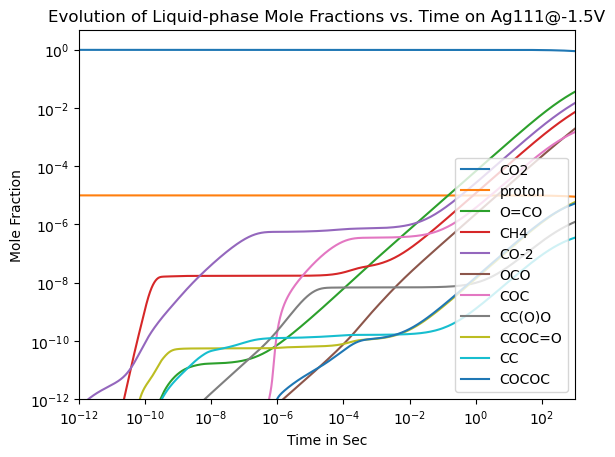

In [499]:
exclude_species = ["H2O"]
plotX(ssys.sims[1], 1e-7, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e3)
ylim(1e-12, 5)
title("Evolution of Liquid-phase Mole Fractions vs. Time on Ag111@-1.5V")
gcf()

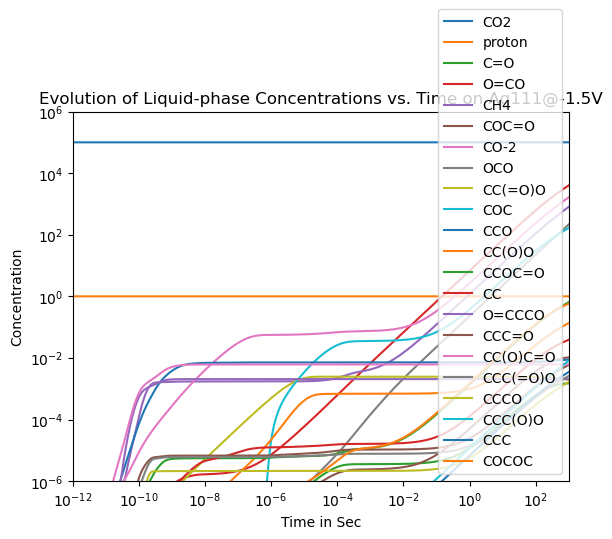

In [500]:
exclude_species = ["H2O"]
plotC(ssys.sims[1], 1e-3, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e3)
ylim(1e-6, 1e6)
title("Evolution of Liquid-phase Concentrations vs. Time on Ag111@-1.5V")
gcf()

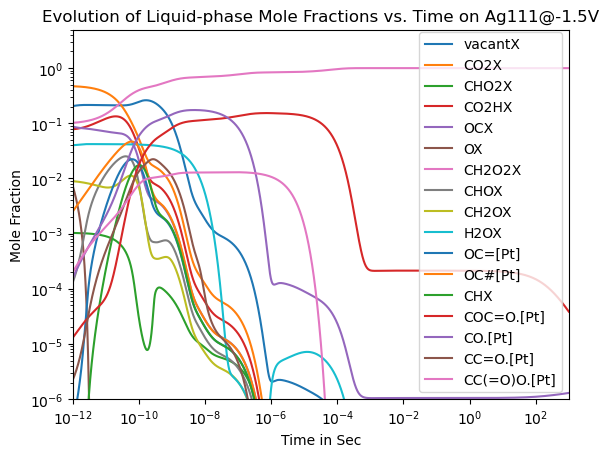

In [501]:
exclude_species = ["H2O"]
plotX(ssys.sims[2], 1e-2, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e3)
ylim(1e-6, 5)
title("Evolution of Liquid-phase Mole Fractions vs. Time on Ag111@-1.5V")
gcf()

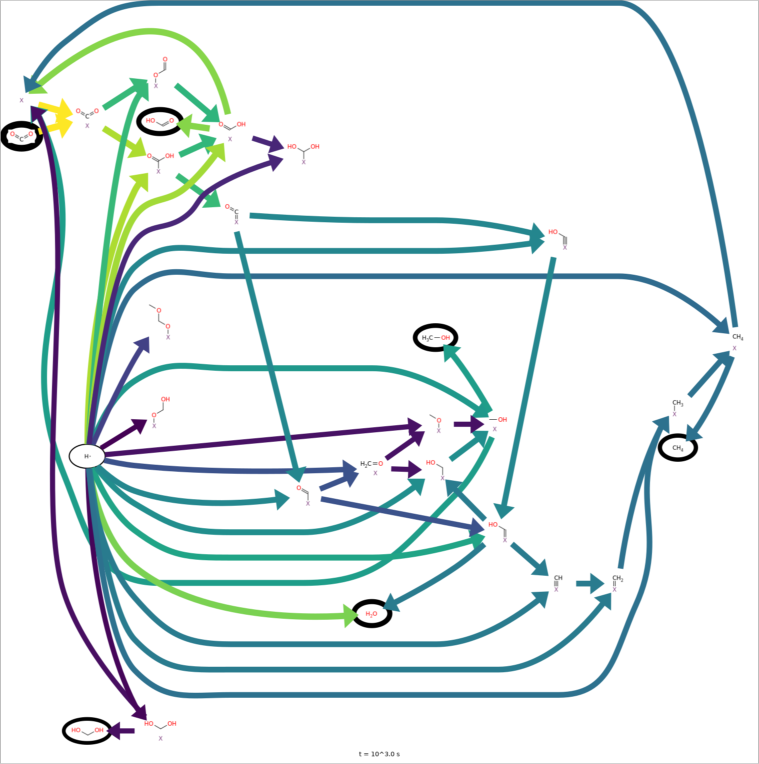

In [502]:
getfluxdiagram(ssys,1e3;speciesratetolerance=1e-6)

In [503]:
println(ssys.names)

In [504]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

In [505]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end